In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('concrete_data_yeh.csv')

# Extract independent variables (X) and dependent variable (Y - 'csMPa')
X = data[['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age']].values
Y = data['csMPa'].values.reshape(-1, 1)

# Add a bias term (column of ones) to X (this is basically like a dummy variable - I add it at the start of the matrix)
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

# Compute output using the analtyical solution given in the classroom
output_0 = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ Y

print("Estimated output:", output_0)


Estimated output: [[-2.33312136e+01]
 [ 1.19804334e-01]
 [ 1.03865809e-01]
 [ 8.79343215e-02]
 [-1.49918419e-01]
 [ 2.92224595e-01]
 [ 1.80862148e-02]
 [ 2.01903511e-02]
 [ 1.14222068e-01]]


In [11]:
from sklearn.metrics import mean_squared_error as mse

# Split the data into training and validation sets (75% training, 25% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_bias, Y, test_size=0.25, random_state=42)

# Function to train a linear model and calculate MSE
def train_and_evaluate(X_train, Y_train, X_val, Y_val, num_features):
    X_train_subset = X_train[:, :num_features+1]  # +1 to account for bias term
    X_val_subset = X_val[:, :num_features+1] # same same
    
    # Compute output for the subset of features
    output = np.linalg.inv(X_train_subset.T @ X_train_subset) @ X_train_subset.T @ Y_train
    
    # Predictions on validation set
    Y_pred = X_val_subset @ output
    
    # Calculate MSE
    error = mse(Y_val, Y_pred)
    
    return error, output

# Train models with 7, 8, and 9 features
mse_7, beta_7 = train_and_evaluate(X_train, Y_train, X_val, Y_val, 7)
mse_8, beta_8 = train_and_evaluate(X_train, Y_train, X_val, Y_val, 8)
mse_9, beta_9 = train_and_evaluate(X_train, Y_train, X_val, Y_val, 9)

print(f'MSE with 7 features: {mse_7}')
print(f'MSE with 8 features: {mse_8}')
print(f'MSE with 9 features: {mse_9}')


MSE with 7 features: 155.31146876288008
MSE with 8 features: 101.58139562952697
MSE with 9 features: 101.58139562952697


# Write-up for Problem 1

### What do you observe from the MSE results of these models? Do models with more independent variables always perform better? You may select any combination of independent variables for your models.

Models with more variables don't necessarily improve accuracy. In fact, it can even suggest overfitting (I believe this is why techniques like pruning exist). For instance, in our model, the MSE error did not drop from 101.58 between feature 8 and feature 9.

<br>

<br>

# Problem 2 Now

In [23]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [25]:
# Apple Silicon acceleration :)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f'Using device: {device}')

Using device: mps


extractor(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dim_redu): Sequential(
    (0): Linear(in_features=1568, out_features=256, bias=True)
    (1): Tanh()
  )
)

In [26]:
# Load the pre-trained feature extractor (encoder.py is assumed to be imported)
feature_extractor = extractor().to(device) # using the gpu
feature_extractor.load_state_dict(torch.load('feature_extractor_weights.pth', map_location=device))
feature_extractor.eval()  # Set to evaluation mode

extractor(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dim_redu): Sequential(
    (0): Linear(in_features=1568, out_features=256, bias=True)
    (1): Tanh()
  )
)

In [27]:
# Initialize logistic regression model with random weights - we could do zeros too but no need to
def initialize_logistic_model(input_dim, num_classes):
    W = torch.randn((input_dim, num_classes), device=device) * 0.01  # Random initialization with small values
    b = torch.randn((1, num_classes), device=device) * 0.01
    return W, b

# Softmax function using PyTorch for GPU computation
def softmax(x):
    exp_logits = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
    return exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)

# Cross-entropy loss function
def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    neg_log_likelihood = -torch.log(y_pred[range(m), y_true])
    return torch.sum(neg_log_likelihood) / m

# SGD update
def sgd_update(W, b, dW, db, eta):
    W -= eta * dW
    b -= eta * db
    return W, b


In [28]:

def train_logistic_regression(feature_extractor, train_loader, input_dim, num_classes, eta, num_epochs):
    W, b = initialize_logistic_model(input_dim, num_classes)
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Extract latent features from the feature extractor
            with torch.no_grad():
                latent_features = feature_extractor(images).to(device)
            
            # Forward pass: compute logits and apply softmax
            input = torch.mm(latent_features, W) + b
            y_pred = softmax(input)
            
            # Compute loss
            loss = cross_entropy_loss(y_pred, labels)
            epoch_loss += loss.item()
            
            # Backward pass: compute gradients
            m = labels.size(0)
            y_pred[range(m), labels] -= 1  # Subtract 1 from the correct class probabilities
            dW = torch.mm(latent_features.T, y_pred) / m
            db = torch.sum(y_pred, dim=0, keepdim=True) / m
            
            # Update weights and bias using SGD
            W, b = sgd_update(W, b, dW, db, eta)
        
        # Average epoch loss
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
    
    return W, b, train_losses



In [29]:
# Train the model on the MPS device (GPU)
input_dim = 256  # Output dimension of the feature extractor
num_classes = 10  # MNIST has 10 classes
eta = 0.1  # Learning rate
num_epochs = 10

W, b, train_losses = train_logistic_regression(feature_extractor, train_loader, input_dim, num_classes, eta, num_epochs)



Epoch 1/10, Loss: 0.034895983142609485
Epoch 2/10, Loss: 0.009101646828841466
Epoch 3/10, Loss: 0.006269101825720722
Epoch 4/10, Loss: 0.004884368563661657
Epoch 5/10, Loss: 0.004071876530004079
Epoch 6/10, Loss: 0.0035017189017915503
Epoch 7/10, Loss: 0.00308869679196629
Epoch 8/10, Loss: 0.0027754785175868263
Epoch 9/10, Loss: 0.00252601444023847
Epoch 10/10, Loss: 0.002321081664246906


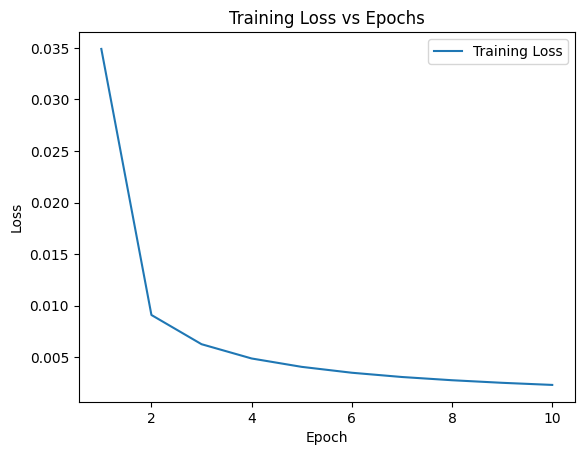

In [30]:
# Plot the training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

# Problem 3 done on pen and paper and submitted as a PDF